In [2]:
import pandas as pd
import numpy as np
import pickle
import gzip
import os

import vae_tools
import vae_tools.viz
import vae_tools.sanity
vae_tools.sanity.check()
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss

import gym
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras.layers import Input, Dense, Lambda, Layer, Conv1D, Reshape, Flatten
from sklearn.manifold import TSNE
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

from utils.visualize import *
from utils.data_tools import periodic
from evaluate import pearson

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True
keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


Paper for gym Robot environments: <small>https://arxiv.org/pdf/1802.09464.pdf</small>

In [3]:
touch = pd.read_csv('data/normalized_touch_data', index_col=0)
proprio = pd.read_csv('data/normalized_proprio_data', index_col=0)
object_quat = pd.read_csv('data/unnormalized_object_quat_data', index_col=0)
euler_angles = pd.read_csv('data/euler_angles', index_col=0)

## Train Object Pose Model

In [5]:
quat_data = np.array(object_quat)

batch_size = 128
dims = len(object_quat.columns)
hidden_dims = 32
beta_norm = 0.01
z_dim = 20
epochs = 15
load_weights = True

quat_encoder = [[
    Input(shape=(dims,)),
    Dense(hidden_dims, activation='relu'),
    Dense(hidden_dims//2, activation='relu'),
]]

quat_decoder = [[
    Dense(hidden_dims//2, activation='relu'),
    Dense(hidden_dims, activation='elu'),
    Dense(dims, activation=None),
]]

quat_vea = MmVae(z_dim, quat_encoder, quat_decoder, [dims], beta_norm, beta_is_normalized=True,
                  reconstruction_loss_metrics=[ReconstructionLoss.MSE], name='quat_vae')
vae = quat_vea.get_model()
vae.compile(optimizer='rmsprop')

losses_cb = vae_tools.callbacks.Losses(data=quat_data)

if load_weights:
    vae.load_weights('models/object_pose/object_pose')
else:
    vae.fit(quat_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/object_pose/object_pose')

    vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)

# Get the models
encoder_input = [quat_encoder[0][0]]
encoder_quat = quat_vea.get_encoder_mean(encoder_input)
# encode
quat_encoded = encoder_quat.predict(quat_data)

In [4]:
#[:10000])

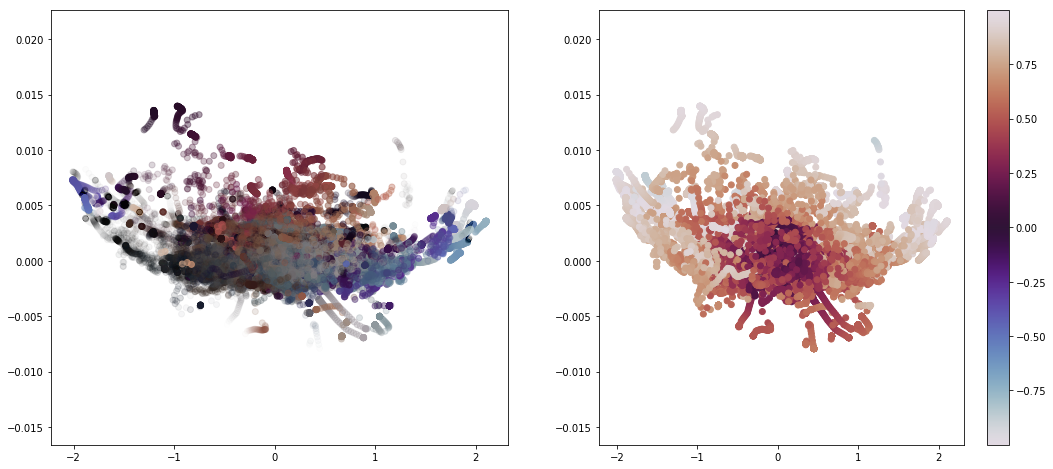

In [8]:
num_samples = 50000
n_test_data = 50000
plot_data = quat_data[:num_samples]
max_pos = np.max(plot_data[:, :3], 0)

cmap = plt.get_cmap('twilight')
#sigmoid = lambda x: 1/(1+np.exp(-x))

color_by_x_pos = [ d[0]/max_pos[0] for d in plot_data ]
color_by_rot = [ Quaternion(d[3:]).angle/np.pi for d in plot_data ]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
c3 = euler_angles[:n_test_data].to_numpy()
c3 = [ (np.array(cmap(r))) * [1,1,1,e] * y for r, e, y in c3 ]
plt.scatter(quat_encoded[:num_samples, 0], quat_encoded[:num_samples, 1], c=c3)
plt.subplot(1, 2, 2)
plt.scatter(quat_encoded[:num_samples, 0], quat_encoded[:num_samples, 1], c=color_by_rot, cmap='twilight')
plt.colorbar()

## Train touch model

In [9]:
touch_data = np.array(touch)#[:200000]

batch_size = 512
dims = len(touch.columns)
hidden_dims = 128
beta_norm = 0.08
z_dim = 20
epochs = 15
load_weights = True

touch_encoder = [[
    Input(shape=(dims,)),
    #Reshape((dims, 1)),
    #Conv1D(128, 7, 4, activation='relu'),
    #Flatten(),
    Dense(hidden_dims, activation='relu'),
    Dense(hidden_dims, activation='relu'),
    Dense(hidden_dims//2, activation='relu'),
    Dense(hidden_dims//4, activation='relu'),
]]

touch_decoder = [[
    Dense(hidden_dims//2, activation='elu'),
    Dense(hidden_dims, activation='elu'),
    Dense(dims, activation='sigmoid'),
]]

touch_vea = MmVae(z_dim, touch_encoder, touch_decoder, [dims], beta_norm, beta_is_normalized=False,
                  reconstruction_loss_metrics=[ReconstructionLoss.MSE], name='touch_vae')
vae = touch_vea.get_model()
vae.compile(optimizer='adam')

losses_cb = vae_tools.callbacks.Losses(data=touch_data)

if load_weights:
    vae.load_weights('models/touch/touch')
else:
    vae.fit(touch_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/touch/touch')
    vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)
    
encoder_input = [touch_encoder[0][0]]
encoder_touch = touch_vea.get_encoder_mean(encoder_input)
touch_encoded = encoder_touch.predict(touch_data)

In [10]:
from scipy.stats import pearsonr

pearsonr(touch_encoded.ravel(), quat_encoded.ravel())

(-0.005536739, 6.852708749803917e-57)

## Train Proprioceptive Model

In [11]:
proprio_data = np.array(proprio)

batch_size = 128
dims = len(proprio.columns)
hidden_dims = 32
beta_norm = 0.01
z_dim = 20
epochs = 15
load_weights = True

proprio_encoder = [[
    Input(shape=(dims,)),
    Dense(hidden_dims, activation='elu'),
    Dense(hidden_dims//2, activation='elu'),
]]

proprio_decoder = [[
    Dense(hidden_dims//2, activation='elu'),
    Dense(hidden_dims, activation='elu'),
    Dense(dims, activation='tanh'),
]]

proprio_vea = MmVae(z_dim, proprio_encoder, proprio_decoder, [dims], beta_norm, beta_is_normalized=True,
                  reconstruction_loss_metrics=[ReconstructionLoss.MSE], name='proprio_vae')
vae = proprio_vea.get_model()
vae.compile(optimizer='adam')

losses_cb = vae_tools.callbacks.Losses(data=proprio_data)


if load_weights:
    vae.load_weights('models/proprio/proprio')
else:
    vae.fit(proprio_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/proprio/proprio')

    vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)

encoder_input = [proprio_encoder[0][0]]
encoder_prop = proprio_vea.get_encoder_mean(encoder_input)
prop_encoded = encoder_prop.predict(proprio_data)

<Figure size 576x576 with 0 Axes>

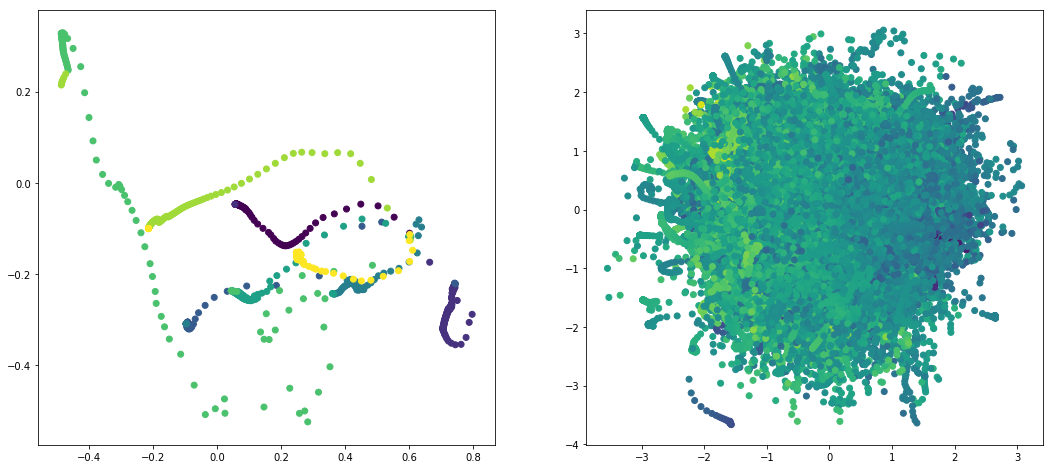

In [12]:
# Get the models
encoder_input = [proprio_encoder[0][0]]
encoder_prop = proprio_vea.get_encoder_mean(encoder_input)

prop_encoded = encoder_prop.predict(proprio_data[:-80])
prop_encoded_single = prop_encoded[:800]

plt.figure(figsize=(8, 8))
# colorize single trajectories
colors_single = np.ravel([ [i]*100 for i in range(len(prop_encoded_single)//100) ])
# 
colors = [ np.sum(d) for d in proprio_data[:-80] ]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.scatter(prop_encoded_single[:, 0], prop_encoded_single[:, 1], c=colors_single)                           
plt.subplot(1, 2, 2)
plt.scatter(prop_encoded[:, 0], prop_encoded[:, 1], c=colors)

## Bimodel VAE: Touch and Proprioceptive Model

In [15]:
tp_data = [touch_data, proprio_data]

batch_size = 16
beta_norm = 0.01
z_dim = 20
epochs = 15
dims = [len(touch.columns), len(proprio.columns)]
load_weights = True

tp_encoders = [touch_encoder[0], proprio_encoder[0]]
tp_decoders = touch_decoder + proprio_decoder

# fix weights of the monomodal models
for layer in touch_encoder[0] + proprio_encoder[0]:
    layer.trainable = False
for layer in touch_decoder[0][1:] + proprio_decoder[0][1:]:
    layer.trainable = False

tp_vae = MmVae(z_dim, tp_encoders, tp_decoders, dims, beta_norm, beta_is_normalized=True,
               reconstruction_loss_metrics=[ReconstructionLoss.MSE], name='tp_vae')
vae = tp_vae.get_model()
vae.compile(optimizer='adam')

losses_cb = vae_tools.callbacks.Losses(data=tp_data)

if load_weights:
    vae.load_weights('models/touch_prop/touch_prop')
else:
    vae.fit(tp_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/touch_prop/touch_prop')

    #vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)

A: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]
A: [<tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]


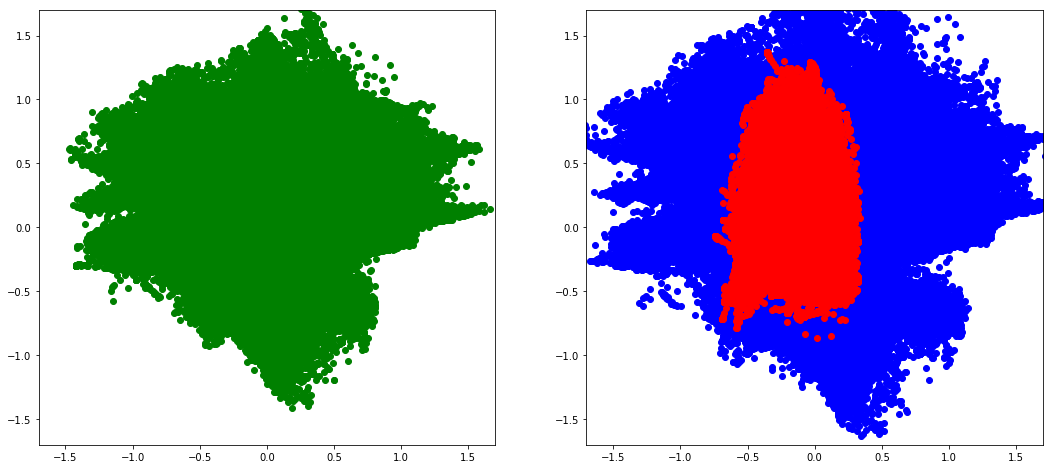

In [16]:
# Get the models
encoder_input = [tp_encoders[0][0], tp_encoders[1][0]]
encoder_tp = [tp_vae.get_encoder_mean([encoder_input[0]]),
                tp_vae.get_encoder_mean([encoder_input[1]]),
                tp_vae.get_encoder_mean(encoder_input)]
encoder_logvar = [tp_vae.get_encoder_logvar([encoder_input[0]]),
                  tp_vae.get_encoder_logvar([encoder_input[1]]),
                  tp_vae.get_encoder_logvar(encoder_input)]

plt.figure(figsize=(18, 8))
tp_encoded = encoder_tp[-1].predict(tp_data)
plt.subplot(1, 2, 1)
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(tp_encoded[:, 0], tp_encoded[:, 1], c='g')
mean_encoded = encoder_tp[0].predict(tp_data[0])
plt.subplot(1, 2, 2)
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='b')
mean_encoded = encoder_tp[1].predict(tp_data[1])
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='r')

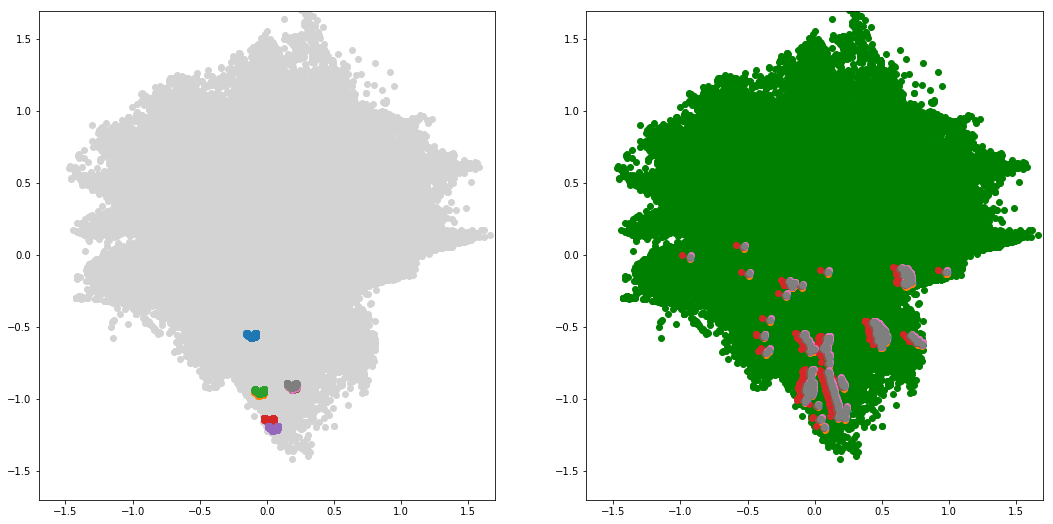

In [17]:
%matplotlib qt

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
#plt.xlim((.05, -.2))
#plt.ylim((-.6, -.7))

plt.scatter(tp_encoded[:, 0], tp_encoded[:, 1], c='lightgrey')

for i in range(8):
    n_samples = 1000
    touch_sample = np.tile(touch_data[i], [n_samples, 1])
    touch_fix_data = [touch_sample, proprio_data[:n_samples]]
    encoded = encoder_tp[-1].predict(touch_fix_data)
    plt.scatter(encoded[:, 0], encoded[:, 1])
    


plt.subplot(1, 2, 2)
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(tp_encoded[:, 0], tp_encoded[:, 1], c='g')

for i in range(8):
    n_samples = 1000
    prop_sample = np.tile(proprio_data[200*i], [n_samples, 1])
    prop_fix_data = [touch_data[:n_samples], prop_sample]
    encoded = encoder_tp[-1].predict(prop_fix_data)
    plt.scatter(encoded[:, 0], encoded[:, 1])

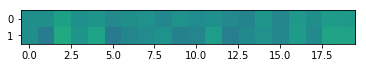

In [20]:
plt.imshow(pearson(tp_encoded, quat_encoded)[0], vmin=-1, vmax=1)

## 3 Modalities: Touch, Proprioceptive, Obj-Pose

In [24]:
tpo_data = [touch_data, proprio_data, quat_data]

batch_size = 128
beta_norm = 0.05
dims = [len(touch.columns), len(proprio.columns), len(object_quat.columns)]
z_dim = 20
epochs = 15
load_weights = True

tpo_encoders = touch_encoder + proprio_encoder + quat_encoder
tpo_decoders = touch_decoder + proprio_decoder + quat_decoder

# fix weights of the monomodal models
for layer in touch_encoder[0] + proprio_encoder[0] + quat_encoder[0]:
    layer.trainable = False
for layer in touch_decoder[0][1:] + proprio_decoder[0][1:] + quat_decoder[0][1:]:
    layer.trainable = False

tpo_vae = MmVae(z_dim, tpo_encoders, tpo_decoders, dims, beta_norm, beta_is_normalized=True,
               reconstruction_loss_metrics=[ReconstructionLoss.BCE], name='tp_vae')
vae = tpo_vae.get_model()
vae.compile(optimizer='adam')

losses_cb = vae_tools.callbacks.Losses(data=tpo_data)

if load_weights:
    vae.load_weights('models/touch_prop_pose/touch_prop_pose')
else:
    vae.fit(tpo_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/touch_prop_pose/touch_prop_pose')
    
#vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)

A: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]
A: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 7) dtype=float32>]
A: [<tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]
A: [<tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_4:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 7) dtype=float32>]
A: [<tf.Tensor 'input_2:0' shape=(?, 7) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_3:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 7) dtype=float32>]
A: [<tf.Tensor 'input_2:0' shape=(?, 7) dtype=float32>]  is prop

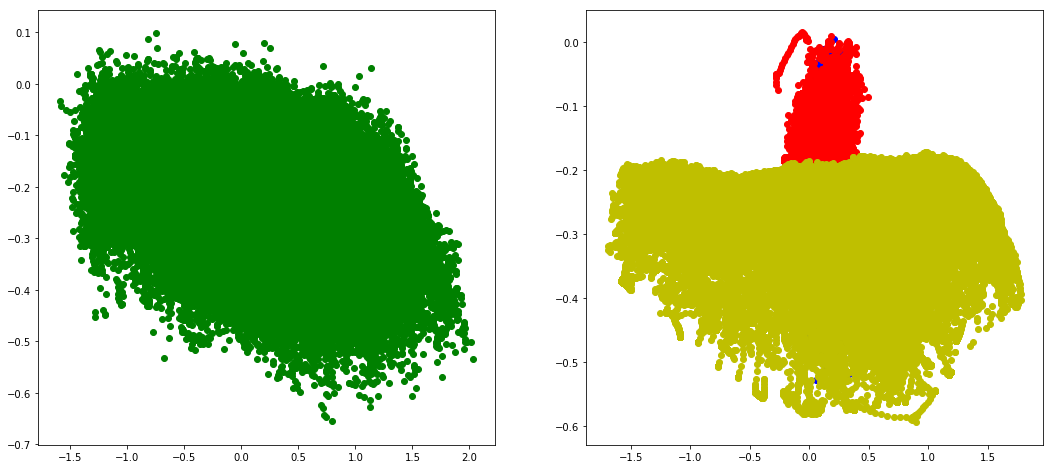

In [25]:
# Get the models
encoder_input = [tpo_encoders[0][0], tpo_encoders[1][0], tpo_encoders[2][0]]
encoder_tpo = [tpo_vae.get_encoder_mean([encoder_input[0]]),
                tpo_vae.get_encoder_mean([encoder_input[1]]),
                tpo_vae.get_encoder_mean([encoder_input[2]]),
                tpo_vae.get_encoder_mean([encoder_input[0], encoder_input[1]]), # touch + proprioceptive
                tpo_vae.get_encoder_mean(encoder_input)]


plt.figure(figsize=(18, 8))
tpo_encoded = encoder_tpo[-1].predict(tpo_data)
plt.subplot(1, 2, 1)
#plt.xlim((-0.06, 0.06))
#plt.ylim((-0.06, 0.06))
plt.scatter(tpo_encoded[:, 0], tpo_encoded[:, 1], c='g')
plt.subplot(1, 2, 2)

# touch
t_encoded = encoder_tpo[0].predict(tpo_data[0])
plt.scatter(t_encoded[:, 0], t_encoded[:, 1], c='b')
# proprioceptive
p_encoded = encoder_tpo[1].predict(tpo_data[1])
plt.scatter(p_encoded[:, 0], p_encoded[:, 1], c='r')
# object pose
o_encoded = encoder_tpo[2].predict(tpo_data[2])
plt.scatter(o_encoded[:, 0], o_encoded[:, 1], c='y')

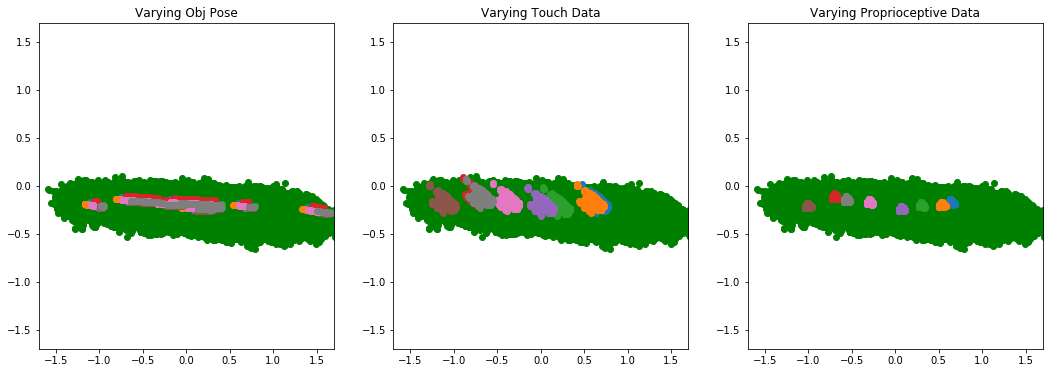

In [26]:
n_samples = 1000

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Varying Obj Pose')
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(tpo_encoded[:, 0], tpo_encoded[:, 1], c='g')

for i in range(8):
    n_samples = 1000
    touch_sample = np.tile(touch_data[100*i], [n_samples, 1])
    prop_sample = np.tile(proprio_data[100*i], [n_samples, 1])
    touch_fix_data = [touch_sample, prop_sample, quat_data[:n_samples]]
    encoded = encoder_tpo[-1].predict(touch_fix_data)
    plt.scatter(encoded[:, 0], encoded[:, 1])

plt.subplot(1, 3, 2)
plt.title('Varying Touch Data')
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(tpo_encoded[:, 0], tpo_encoded[:, 1], c='g')

for i in range(8):
    n_samples = 1000
    prop_sample = np.tile(proprio_data[100*i], [n_samples, 1])
    quat_sample = np.tile(quat_data[100*i], [n_samples, 1])
    prop_fix_data = [touch_data[:n_samples], prop_sample, quat_sample]
    encoded = encoder_tpo[-1].predict(prop_fix_data)
    plt.scatter(encoded[:, 0], encoded[:, 1])
    
plt.subplot(1, 3, 3)
plt.title('Varying Proprioceptive Data')
plt.xlim((-1.7, 1.7))
plt.ylim((-1.7, 1.7))
plt.scatter(tpo_encoded[:, 0], tpo_encoded[:, 1], c='g')

for i in range(8):
    n_samples = 1000
    touch_sample = np.tile(touch_data[100*i], [n_samples, 1])
    quat_sample = np.tile(quat_data[100*i], [n_samples, 1])
    quat_fix_data = [touch_sample, proprio_data[:n_samples], quat_sample]
    encoded = encoder_tpo[-1].predict(quat_fix_data)
    plt.scatter(encoded[:, 0], encoded[:, 1])

In [27]:
# encode touch and proprioceptive data
tp_encoded = encoder_tpo[3].predict(tp_data)
corr, p = pearson(tp_encoded, o_encoded)

In [28]:
corr[np.argsort(corr, axis=0)].shape

(20, 20, 20)

## Correlation Plots

In [29]:
%matplotlib qt

#scorr = np.argsort(corr, axis=1)
#scorr = np.argsort(np.sort(corr, axis=1), axis=0)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.xticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
plt.yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
plt.ylabel('Touch & proprioceptive')
plt.xlabel('Object pose')
plt.imshow(corr)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.ylabel('Touch & proprioceptive')
plt.xlabel('Object pose')
plt.xticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
plt.yticks(ticks=[0, 4, 9, 14, 19], labels=[1, 5, 10, 15, 20])
plt.imshow(p)
plt.colorbar()

In [69]:
np.std(np.where(np.abs(p) < 0.001, p, 0))

7.76594123372811e-06

In [71]:
7.7e-6 == 0.0000077

True

In [78]:
# get a sample value to encode
base_sample = [ [d[80]] for d in tp_data ]
encoded_sample = encoder_tpo[3].predict(base_sample)
print(encoded_sample.shape)
# get the decoder
decoder = tpo_vae.get_decoder()

fig = plt.figure(figsize=(18, 8))

for i in range(18):
    decoded = decoder.predict(encoded_sample)
    estimate_pose = decoded[-1][0]
    ax = plt.subplot(2, 18, i+1, projection='3d', aspect='equal')
    visualize_object(*estimate_pose[:3], estimate_pose[3:], ax=ax, plot_origin=False, fix_axes=True, obj='cube')
    estimate_pose[-1]
    encoded_sample[0,-1] += 0.1
    if i == 0:
        ax.text(-3, 20, 0, 'tweaking correlated dims', fontsize=18)

for i in range(18):
    decoded = decoder.predict(encoded_sample)
    estimate_pose = decoded[-1][0]
    ax = plt.subplot(2, 18, i+1+18, projection='3d', aspect='equal')
    visualize_object(*estimate_pose[:3], estimate_pose[3:], ax=ax, plot_origin=False, fix_axes=True, obj='cube')
    estimate_pose[-1]
    encoded_sample[0,11] += 0.1
    if i == 0:
        ax.text(-3, 20, 0, 'tweaking uncorrelated dims', fontsize=18)

(1, 20)


In [49]:
estimate_pose[:3]

array([[ 1.0134845 ,  0.84720147,  0.18220401,  0.85156786, -0.16704386,
        -0.1290163 , -0.3872084 ]], dtype=float32)

In [126]:
len(tp_data[0]), len(o_encoded)

(412080, 412080)

In [ ]:
pearsonr(tp_encoded[:100, i], o_encoded[:100, j])

In [253]:
n_samples = 1000
test_idx = np.random.choice(range(len(tpo_data[0])), size=n_samples)

sample = [tpo_data[0][test_idx], tpo_data[1][test_idx], tpo_data[2][test_idx]]

encode_test = encoder_mean[-1].predict(sample)
decode_test = tpo_vae.get_decoder().predict(encode_test)

mod_a_errors = (np.mean(np.array(decode_test[0]) - np.array(sample[0])))
mod_b_errors = (np.mean(np.array(decode_test[1]) - np.array(sample[1])))
mod_c_errors = (np.mean(np.array(decode_test[2]) - np.array(sample[2])))
max_a_errors = (np.max(np.array(decode_test[0]) - np.array(sample[0])))
max_b_errors = (np.max(np.array(decode_test[1]) - np.array(sample[1])))
max_c_errors = (np.max(np.array(decode_test[2]) - np.array(sample[2])))
    
print('Mean Error Modality A:', mod_a_errors)
print('Mean Error Modality B:', mod_b_errors)
print('Mean Error Modality C:', mod_c_errors)
print('Max Error Modality A:', max_a_errors)
print('Max Error Modality B:', max_b_errors)
print('Max Error Modality C:', max_c_errors)

Mean Error Modality A: -0.0041103167
Mean Error Modality B: -0.00034464558
Mean Error Modality C: 0.004940368
Max Error Modality A: 0.70728755
Max Error Modality B: 0.64095634
Max Error Modality C: 0.9922675


## 4ModVAE

In [ ]:
multi_data = [touch_data, proprio_data, quat_data, velocity_data]

batch_size = 512
beta_norm = 0.1
z_dim = 2
epochs = 10
load_weights = False
dims = [len(touch.columns), len(proprio.columns), len(object_quat.columns), len(object_vel.columns)]

multi_encoders = touch_encoder + proprio_encoder + quat_encoder + velocity_encoder
multi_decoders = touch_decoder + proprio_decoder + quat_decoder + velocity_decoder

# fix weights of the monomodal models
for layer in touch_encoder[0] + proprio_encoder[0] + quat_encoder[0] + velocity_encoder[0]:
    layer.trainable = False
for layer in touch_decoder[0][1:] + proprio_decoder[0][1:] + quat_decoder[0][1:] + velocity_decoder[0][1:]:
    layer.trainable = False

multi_vae = MmVae(z_dim, multi_encoders, multi_decoders, dims, beta_norm, beta_is_normalized=True,
               reconstruction_loss_metrics=[ReconstructionLoss.MSE], name='multi_vae')
vae = multi_vae.get_model()
vae.compile(optimizer='adam')

losses_cb = vae_tools.callbacks.Losses(data=multi_data)

if load_weights:
    vae.load_weights('models/touch_prop_pose_vel/touch_prop_pose_vel')
else:
    vae.fit(multi_data, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[losses_cb])
    vae.save_weights('models/touch_prop_pose_vel/touch_prop_pose_vel')
    
vae_tools.viz.plot_losses(losses_cb, plot_elbo=True)

A: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>]
A: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 7) dtype=float32>]
A: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_7:0' shape=(?, 6) dtype=float32>]
A: [<tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_5:0' shape=(?, 92) dtype=float32>, <tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>]
A: [<tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 7) dtype=float32>]
A: [<tf.Tensor 'input_6:0' shape=(?, 24) dtype=float32>]  is pr

Epoch 1/10
103020/103020 [==============================] - 60s 585us/step - loss: 212.6166
Epoch 2/10
103020/103020 [==============================] - 44s 430us/step - loss: 73.8837
Epoch 3/10
103020/103020 [==============================] - 45s 433us/step - loss: 58.8943
Epoch 4/10
103020/103020 [==============================] - 45s 435us/step - loss: 53.3266
Epoch 5/10
103020/103020 [==============================] - 45s 436us/step - loss: 50.5043
Epoch 6/10
103020/103020 [==============================] - 45s 437us/step - loss: 48.7859
Epoch 7/10
103020/103020 [==============================] - 44s 430us/step - loss: 47.6177
Epoch 8/10
103020/103020 [==============================] - 44s 431us/step - loss: 46.7567
Epoch 9/10
102400/103020 [============================>.] - ETA: 0s - loss: 46.1155

In [24]:
# Get the models
encoder_input = [multi_encoders[0][0], multi_encoders[1][0], multi_encoders[2][0], multi_encoders[3][0]]
encoder_mean = [multi_vae.get_encoder_mean([encoder_input[0]]),
                multi_vae.get_encoder_mean([encoder_input[1]]),
                multi_vae.get_encoder_mean([encoder_input[2]]),
                multi_vae.get_encoder_mean([encoder_input[3]]),
                multi_vae.get_encoder_mean(encoder_input)]
encoder_logvar = [multi_vae.get_encoder_logvar([encoder_input[0]]),
                  multi_vae.get_encoder_logvar([encoder_input[1]]),
                  multi_vae.get_encoder_logvar([encoder_input[2]]),
                  multi_vae.get_encoder_logvar([encoder_input[3]]),
                  multi_vae.get_encoder_logvar(encoder_input)]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
mean_encoded = encoder_mean[-1].predict(multi_data)
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='g')
plt.subplot(1, 2, 2)
# proprio
mean_encoded = encoder_mean[3].predict(multi_data[3])
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='c')
# object pose
mean_encoded = encoder_mean[1].predict(multi_data[1])
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='r')
# velocity
mean_encoded = encoder_mean[2].predict(multi_data[2])
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='b')
# touch
mean_encoded = encoder_mean[0].predict(multi_data[0])
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c='m')

NameError: name 'multi_encoders' is not defined

In [101]:
fig = plt.figure(figsize=(18, 18))
plt.tight_layout(pad=0.0)
p = 1

decoder = tpo_vae.get_decoder()
rdm = np.random.normal(size=20)

for i in range(-7, 7):
    rdm[-1] += 0.1
    for j in range(-7, 7):
        rdm[-3] += 0.1
        
        sample = np.reshape(rdm, [1, 20])
        prediction = decoder.predict(sample)[-1][0]
        ax = plt.subplot(14, 14, p, projection='3d', aspect='equal')
        p += 1
        visualize_object(*prediction[:3], prediction[3:], ax=ax, plot_origin=False, fix_axes=True, obj='cube')

In [95]:
[np.random.normal(size=20)]

[array([ 1.68894978, -0.85224805,  0.77866054, -1.74548498, -0.20071649,
        -0.44748928, -0.63713257, -0.63438108, -0.0423863 , -0.56340377,
         0.83735529,  0.03797347,  0.09454408, -1.29196352, -0.02531287,
         0.78575005, -0.05382857, -0.09275422,  0.19384132, -1.15754701])]

In [81]:
fig = plt.figure(figsize=(18, 18))
plt.tight_layout(pad=0.0)
p = 1

decoder = quat_vea.get_decoder()

for i in range(-10, 10):
    for j in range(-10, 10):
        sample = np.array([[i*0.15, j*0.15]])
        prediction = decoder.predict(sample)[0]
        ax = plt.subplot(20, 20, p, projection='3d', aspect='equal')
        p += 1
        visualize_object(*prediction[:3], prediction[3:], ax=ax, plot_origin=False, fix_axes=True, obj='cube')

ValueError: Error when checking input: expected input_12 to have shape (20,) but got array with shape (2,)

In [32]:
r = [1000, 100000]
dat = [ multi_data[i][r[0]:r[1]] for i in range(4) ] 
mean_encoded = encoder_mean[-1].predict(dat)
img = visualize_in_latent_space(mean_encoded, object_quat[r[0]:r[1]], num=r[1]-r[0], obj='cube')
cv2.imshow('ObjPoses', img)
cv2.waitKey(0)

[100. 100.] [900. 900.]


13

<Figure size 1296x432 with 0 Axes>